
IMPROVED MODEL TRAINING PIPELINE

✓ Loaded data: 46421 rows, 57 columns
✓ Filtered dataset size: 46405
✓ Kept 12 classes with >= 30 samples
✓ Found 52 keypoint columns

DATA LEAKAGE CHECKS

1. Time distribution per class:
                         min          max  count
annotation_label                                
C                 822.933333  1784.466667     44
CCR               565.066667   627.866667    943
CHO               165.000000  1082.400000   2716
CSI               627.933333  1784.133333   7371
CST               253.066667  1846.866667  10246
T                 180.533333  1517.066667   3802
TC                210.000000  1691.133333    252
TRE               529.933333   533.000000     47
TSI               241.600000  1759.666667  11432
TST               165.000000  1524.133333   3233
⚠ WARNING: 1 class pairs don't overlap in time:
  - CSI and CCR
  This could indicate temporal leakage if train/test split is not time-aware

2. Feature-target correlation: Skipped (target 

INFO: ✓ Added 16 velocity and 16 acceleration features


✓ Encoded labels: 12 classes
  Classes: ['C' 'CCR' 'CHO' 'CSI' 'CST' 'T' 'TC' 'TRE' 'TSI' 'TST']...

--- Preparing Features ---
Columns before cleanup: 120
Sample columns: ['person_label', 'time_s', 'avg_pose_conf', 'wrist_dist', 'nose_x', 'nose_y', 'neck_x', 'neck_y', 'r_shoulder_x', 'r_shoulder_y']
✓ Converting person_label to dummy variables
Dropping metadata columns: ['time_s', 'avg_pose_conf', 'annotation_label', 'label_class', 'delta_time', 'torso_length', 'label_encoded']
✓ Feature matrix shape: (46405, 114)
✓ Target shape: (46405,)
✓ Number of features: 114
✓ Number of samples: 46405

--- Handling Missing Values ---
NaN values before imputation: 576
NaN values after imputation: 0
✓ Imputed 576 missing values

FEATURE ANALYSIS

Initial features: 114

1. Removing zero-variance features...
   Found 6 zero-variance features

2. Analyzing feature-target correlations...
   Top 10 most correlated features:
   - person_Therapist: 0.8610
   - person_Child: 0.8610
   - neck_x: 0.7929
   

INFO: ✓ Saved: model_comparison.png


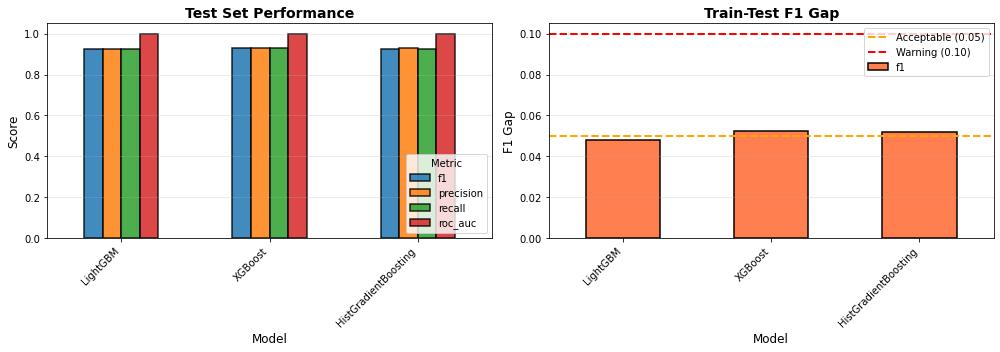


FEATURE IMPORTANCE ANALYSIS


INFO: ✓ Saved: feature_importance.png



CROSS-VALIDATION CHECK (3-Fold, Best Model Only)

Top 15 most important features (XGBoost):
  person_Child                   0.3197
  person_Therapist               0.1734
  r_wrist_x                      0.0337
  nose_to_neck                   0.0237
  r_hip_y                        0.0227
  nose_x                         0.0195
  r_heel_x                       0.0182
  nose_y                         0.0154
  r_small_toe_x                  0.0148
  l_wrist_y                      0.0136
  body_spread_x                  0.0126
  l_knee_x                       0.0124
  r_ankle_y                      0.0120
  l_big_toe_y                    0.0118
  neck_x                         0.0116
Running CV on best model: XGBoost
XGBoost: CV F1 = 0.9181 (+/- 0.0014)
Individual fold scores: ['0.9198', '0.9163', '0.9182']
✓ Low variance in CV scores - model is stable

BEST MODEL: XGBoost
Test F1 Score: 0.9280
Overfitting Status: good

✓ Saved all models and artifacts to /home/liubov/Bureau/new/output

In [19]:
"""
Improved Feature Selection and Model Training Pipeline
======================================
IMPROVEMENTS:
1. Fixed velocity and acceleration calculations (proper time-based derivatives)
2. Removed PCA - keeping all features for models that handle high dimensionality
3. Better NaN handling (median imputation instead of zero-filling)
4. Using top 3 models that handle many features: LightGBM, XGBoost, HistGradientBoosting
5. Added data leakage checks and overfitting detection
"""
import os
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import joblib  
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# =============================================================================
# HELPER FUNCTIONS 
# =============================================================================

def add_derived_pose_features(df):
    """
    Add comprehensive joint angles, distances, and symmetry features.
    """
    
    def compute_angle(a, b, c):
        """Compute angle at point b formed by points a-b-c"""
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
        return np.arccos(np.clip(cosine_angle, -1.0, 1.0)) * (180.0 / np.pi)

    def compute_distance(p1, p2):
        """Euclidean distance between two points"""
        return np.linalg.norm(p1 - p2)

    # === JOINT ANGLES ===
    df['r_elbow_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['r_shoulder_x'], row['r_shoulder_y']]),
        np.array([row['r_elbow_x'], row['r_elbow_y']]),
        np.array([row['r_wrist_x'], row['r_wrist_y']])
    ), axis=1)

    df['l_elbow_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['l_shoulder_x'], row['l_shoulder_y']]),
        np.array([row['l_elbow_x'], row['l_elbow_y']]),
        np.array([row['l_wrist_x'], row['l_wrist_y']])
    ), axis=1)

    df['r_shoulder_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['r_shoulder_x'], row['r_shoulder_y']]),
        np.array([row['r_elbow_x'], row['r_elbow_y']])
    ), axis=1)

    df['l_shoulder_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['l_shoulder_x'], row['l_shoulder_y']]),
        np.array([row['l_elbow_x'], row['l_elbow_y']])
    ), axis=1)

    df['r_knee_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['r_hip_x'], row['r_hip_y']]),
        np.array([row['r_knee_x'], row['r_knee_y']]),
        np.array([row['r_ankle_x'], row['r_ankle_y']])
    ), axis=1)

    df['l_knee_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['l_hip_x'], row['l_hip_y']]),
        np.array([row['l_knee_x'], row['l_knee_y']]),
        np.array([row['l_ankle_x'], row['l_ankle_y']])
    ), axis=1)

    df['r_hip_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['mid_hip_x'], row['mid_hip_y']]),
        np.array([row['r_hip_x'], row['r_hip_y']]),
        np.array([row['r_knee_x'], row['r_knee_y']])
    ), axis=1)

    df['l_hip_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['mid_hip_x'], row['mid_hip_y']]),
        np.array([row['l_hip_x'], row['l_hip_y']]),
        np.array([row['l_knee_x'], row['l_knee_y']])
    ), axis=1)

    df['trunk_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['nose_x'], row['nose_y']]),
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    # === DISTANCES ===
    df['eye_to_eye'] = df.apply(lambda row: compute_distance(
        np.array([row['l_eye_x'], row['l_eye_y']]),
        np.array([row['r_eye_x'], row['r_eye_y']])
    ), axis=1)

    df['nose_to_neck'] = df.apply(lambda row: compute_distance(
        np.array([row['nose_x'], row['nose_y']]),
        np.array([row['neck_x'], row['neck_y']])
    ), axis=1)

    df['r_wrist_to_hip'] = df.apply(lambda row: compute_distance(
        np.array([row['r_wrist_x'], row['r_wrist_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    df['l_wrist_to_hip'] = df.apply(lambda row: compute_distance(
        np.array([row['l_wrist_x'], row['l_wrist_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    df['r_wrist_to_nose'] = df.apply(lambda row: compute_distance(
        np.array([row['r_wrist_x'], row['r_wrist_y']]),
        np.array([row['nose_x'], row['nose_y']])
    ), axis=1)

    df['l_wrist_to_nose'] = df.apply(lambda row: compute_distance(
        np.array([row['l_wrist_x'], row['l_wrist_y']]),
        np.array([row['nose_x'], row['nose_y']])
    ), axis=1)

    df['nose_to_ankles'] = df.apply(lambda row: (
        compute_distance(np.array([row['nose_x'], row['nose_y']]),
                         np.array([row['l_ankle_x'], row['l_ankle_y']])) +
        compute_distance(np.array([row['nose_x'], row['nose_y']]),
                         np.array([row['r_ankle_x'], row['r_ankle_y']]))
    ) / 2, axis=1)

    df['hip_to_ankle'] = df.apply(lambda row: (
        compute_distance(np.array([row['mid_hip_x'], row['mid_hip_y']]),
                         np.array([row['l_ankle_x'], row['l_ankle_y']])) +
        compute_distance(np.array([row['mid_hip_x'], row['mid_hip_y']]),
                         np.array([row['r_ankle_x'], row['r_ankle_y']]))
    ) / 2, axis=1)

    # === SYMMETRY FEATURES ===
    df['shoulder_y_diff'] = df['l_shoulder_y'] - df['r_shoulder_y']
    df['hip_y_diff'] = df['l_hip_y'] - df['r_hip_y']
    df['elbow_angle_diff'] = df['l_elbow_angle'] - df['r_elbow_angle']
    df['knee_angle_diff'] = df['l_knee_angle'] - df['r_knee_angle']
    df['wrist_to_hip_diff'] = df['l_wrist_to_hip'] - df['r_wrist_to_hip']
    df['shoulder_angle_diff'] = df['l_shoulder_angle'] - df['r_shoulder_angle']

    df['com_x'] = (df['mid_hip_x'] + df['neck_x']) / 2
    df['com_y'] = (df['mid_hip_y'] + df['neck_y']) / 2
    
    df['body_spread_x'] = df[['l_wrist_x', 'r_wrist_x', 'l_ankle_x', 'r_ankle_x']].max(axis=1) - \
                          df[['l_wrist_x', 'r_wrist_x', 'l_ankle_x', 'r_ankle_x']].min(axis=1)
    df['body_spread_y'] = df[['nose_y', 'l_ankle_y', 'r_ankle_y']].max(axis=1) - \
                          df[['nose_y', 'l_ankle_y', 'r_ankle_y']].min(axis=1)

    return df


def add_temporal_features_fixed(df, keypoints, fps=15):
    """
    FIXED: Proper velocity and acceleration calculations
    - Velocity = change in position / change in time (units/second)
    - Acceleration = change in velocity / change in time (units/second²)
    - No zero-filling for NaNs, they will be handled later with proper imputation
    """
    df = df.sort_values(by=['annotation_label', 'time_s']).reset_index(drop=True)
    
    # Calculate time differences properly
    df['delta_time'] = df.groupby('annotation_label')['time_s'].diff()
    
    # For first frame in each sequence, use median frame time
    median_frame_time = 1 / fps
    df['delta_time'] = df['delta_time'].fillna(median_frame_time)
    
    # Clip extremely small values to avoid division issues
    df['delta_time'] = df['delta_time'].clip(lower=0.001)
    
    # Select keypoints for velocity/acceleration
    selected_keypoints = [
        'com_x', 'com_y', 'nose_x', 'nose_y',
        'l_wrist_x', 'l_wrist_y', 'r_wrist_x', 'r_wrist_y',
        'l_ankle_x', 'l_ankle_y', 'r_ankle_x', 'r_ankle_y',
        'neck_x', 'neck_y', 'mid_hip_x', 'mid_hip_y'
    ]
    
    velocity_features = []
    acceleration_features = []
    
    for col in selected_keypoints:
        if col not in df.columns:
            continue
        
        # VELOCITY: (position_t - position_t-1) / delta_time
        position_diff = df.groupby('annotation_label')[col].diff()
        velocity = position_diff / df['delta_time']
        vel_col = f'{col}_vel'
        df[vel_col] = velocity
        velocity_features.append(vel_col)
        
        # ACCELERATION: (velocity_t - velocity_t-1) / delta_time
        velocity_diff = df.groupby('annotation_label')[vel_col].diff()
        acceleration = velocity_diff / df['delta_time']
        acc_col = f'{col}_acc'
        df[acc_col] = acceleration
        acceleration_features.append(acc_col)
    
    # Remove infinite values (but keep NaN for proper imputation later)
    for col in velocity_features + acceleration_features:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    
    logger.info(f"✓ Added {len(velocity_features)} velocity and {len(acceleration_features)} acceleration features")
    
    return df, velocity_features + acceleration_features


def normalize_keypoints(df, keypoints):
    """Normalize keypoints relative to torso length"""
    df['torso_length'] = np.sqrt(
        (df['neck_x'] - df['mid_hip_x'])**2 + 
        (df['neck_y'] - df['mid_hip_y'])**2
    )
    
    # Handle zero/invalid torso lengths
    df['torso_length'] = df['torso_length'].replace(0, np.nan)
    median_torso = df['torso_length'].median()
    df['torso_length'] = df['torso_length'].fillna(median_torso)
    df['torso_length'] = df['torso_length'].clip(lower=1e-3)

    for col in keypoints:
        if '_x' in col:
            df[col] = (df[col] - df['mid_hip_x']) / df['torso_length']
        else:
            df[col] = (df[col] - df['mid_hip_y']) / df['torso_length']

    return df


def check_data_leakage(df, target_col='label_encoded', label_col='annotation_label'):
    """
    Check for potential data leakage issues
    """
    print("\n" + "="*70)
    print("DATA LEAKAGE CHECKS")
    print("="*70)
    
    # Check 1: Time-based leakage
    if 'time_s' in df.columns and label_col in df.columns:
        time_label_corr = df.groupby(label_col)['time_s'].agg(['min', 'max', 'count'])
        print("\n1. Time distribution per class:")
        print(time_label_corr.head(10))
        
        # Check if certain classes only appear in specific time ranges
        # Only check classes with enough samples to be meaningful
        classes = df[label_col].value_counts()
        significant_classes = classes[classes >= 100].index.tolist()  # Only check classes with 100+ samples
        
        non_overlapping_pairs = []
        if len(significant_classes) > 1:
            for i, class1 in enumerate(significant_classes[:10]):  # Check first 10 significant classes
                for class2 in significant_classes[i+1:10]:
                    range1 = df[df[label_col] == class1]['time_s'].agg(['min', 'max'])
                    range2 = df[df[label_col] == class2]['time_s'].agg(['min', 'max'])
                    if range1['max'] < range2['min'] or range2['max'] < range1['min']:
                        non_overlapping_pairs.append((class1, class2))
        
        if non_overlapping_pairs:
            print(f" WARNING: {len(non_overlapping_pairs)} class pairs don't overlap in time:")
            for c1, c2 in non_overlapping_pairs[:3]:  # Show first 3
                print(f"  - {c1} and {c2}")
            print("  This could indicate temporal leakage if train/test split is not time-aware")
        else:
            print("✓ Significant classes show temporal overlap")
            
    elif 'time_s' not in df.columns:
        print("\n1. Time-based check: Skipped (time_s not in dataframe)")
    else:
        print("\n1. Time-based check: Skipped (label column not found)")
    
    # Check 2: Feature-target correlation (only if target is numeric)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col != target_col and 'time' not in col]
    
    # Only check correlation if target is numeric
    if target_col in numeric_cols and len(feature_cols) > 0:
        print("\n2. Feature-target correlation check:")
        correlations = df[feature_cols + [target_col]].corr()[target_col].drop(target_col).abs()
        high_corr_features = correlations[correlations > 0.95]
        
        if len(high_corr_features) > 0:
            print(f" WARNING: {len(high_corr_features)} features have suspiciously high correlation (>0.95) with target:")
            print(high_corr_features.head(10))
        else:
            print("✓ No features with suspiciously high correlation to target")
    else:
        print("\n2. Feature-target correlation: Skipped (target is not numeric or no features available)")
    
    # Check 3: Duplicated rows
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"\n WARNING: {dup_count} duplicated rows found - could indicate leakage")
    else:
        print("\n✓ No duplicated rows")
    
    print("="*70 + "\n")


def detect_overfitting(train_scores, test_scores, model_name, threshold=0.10):
    """
    Detect overfitting by comparing train vs test performance
    """
    gap = train_scores['f1'] - test_scores['f1']
    
    print(f"\n--- Overfitting Analysis: {model_name} ---")
    print(f"Train F1: {train_scores['f1']:.4f}")
    print(f"Test F1:  {test_scores['f1']:.4f}")
    print(f"Gap:      {gap:.4f}")
    
    if gap > 0.15:
        print(" SEVERE OVERFITTING detected!")
        return 'severe'
    elif gap > threshold:
        print(" Moderate overfitting detected")
        return 'moderate'
    else:
        print(" No significant overfitting")
        return 'good'


def plot_model_comparison(test_metrics_dict, train_metrics_dict, save_dir=None):
    """
    Create comparison plot for models
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Convert to DataFrame
    test_df = pd.DataFrame(test_metrics_dict).T
    train_df = pd.DataFrame(train_metrics_dict).T
    
    # Test metrics
    test_df.plot(kind='bar', ax=axes[0], edgecolor='black', linewidth=1.5, alpha=0.85)
    axes[0].set_title('Test Set Performance', fontsize=14, weight='bold')
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_xlabel('Model', fontsize=12)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].legend(title='Metric', loc='lower right')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1.05])
    
    # Overfitting gap
    gap_df = train_df - test_df
    gap_df['f1'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black', linewidth=1.5)
    axes[1].axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Acceptable (0.05)')
    axes[1].axhline(y=0.10, color='red', linestyle='--', linewidth=2, label='Warning (0.10)')
    axes[1].set_title('Train-Test F1 Gap', fontsize=14, weight='bold')
    axes[1].set_ylabel('F1 Gap', fontsize=12)
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(Path(save_dir) / 'model_comparison.png', dpi=150, bbox_inches='tight')
        logger.info("✓ Saved: model_comparison.png")
    
    plt.show()
    plt.close()


# =============================================================================
# MAIN PIPELINE
# =============================================================================

def main(results, output_dir=None):
    """
    Improved training pipeline with:
    - Top 3 models for high-dimensional data: LightGBM, XGBoost, HistGradientBoosting
    - No PCA (these models handle many features well)
    - Proper NaN handling with median imputation
    - Data leakage and overfitting checks
    """
    
    print("\n" + "="*70)
    print("IMPROVED MODEL TRAINING PIPELINE")
    print("="*70)
    
    # Load data
    df = results['labeled_features'].copy()
    print(f"\n✓ Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
    
    # Map labels to classes
    label_to_class_map = {
        'CS': 'vocalizations', 'CNS': 'vocalizations', 'TS': 'vocalizations', 'TNS': 'vocalizations',
        'CGO': 'unlabeled', 'TGO': 'unlabeled',
        'TC': 'joint_attention', 'AO': 'joint_attention', 'AT': 'joint_attention',
        'GO': 'joint_attention', 'GT': 'joint_attention',
        'T': 'interactions', 'T_V': 'interactions', 'T_P': 'interactions', 'C': 'interactions',
        'TST': 'coordination', 'THO': 'coordination', 'TSI': 'coordination', 'TLF': 'coordination',
        'TRE': 'coordination', 'TCR': 'coordination', 'CST': 'coordination', 'CHO': 'coordination',
        'CSI': 'coordination', 'CLF': 'coordination', 'CRE': 'coordination', 'CCR': 'coordination'
    }

    df['label_class'] = df['annotation_label'].map(label_to_class_map)
    non_posture_classes = ['vocalizations', 'unlabeled']
    df = df[~df['label_class'].isin(non_posture_classes)]
    print(f"✓ Filtered dataset size: {df.shape[0]}")
    
    # Filter classes with minimum samples
    min_samples = 30
    class_counts = df['annotation_label'].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index.tolist()
    df = df[df['annotation_label'].isin(valid_classes)]
    print(f"✓ Kept {len(valid_classes)} classes with >= {min_samples} samples")

    # Identify keypoints
    keypoints = [col for col in df.columns if '_x' in col or '_y' in col]
    print(f"✓ Found {len(keypoints)} keypoint columns")
    
    # Check for data leakage BEFORE encoding (while annotation_label still exists)
    check_data_leakage(df, target_col='annotation_label', label_col='annotation_label')
    
    # Feature engineering
    print("\n--- Feature Engineering ---")
    df = normalize_keypoints(df, keypoints)
    df = add_derived_pose_features(df)
    df, temporal_features = add_temporal_features_fixed(df, keypoints)

    # Label encoding
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['annotation_label'])
    print(f"✓ Encoded labels: {len(label_encoder.classes_)} classes")
    print(f"  Classes: {label_encoder.classes_[:10]}{'...' if len(label_encoder.classes_) > 10 else ''}")
    
    # Prepare features
    print("\n--- Preparing Features ---")
    print(f"Columns before cleanup: {df.shape[1]}")
    print(f"Sample columns: {list(df.columns[:10])}")
    
    # Save label_encoded before any operations
    if 'label_encoded' not in df.columns:
        raise ValueError("label_encoded not found! Check previous steps.")
    y = df['label_encoded'].copy()
    
    # Handle person_label if exists (convert to dummy variables)
    if 'person_label' in df.columns:
        print("✓ Converting person_label to dummy variables")
        df = pd.get_dummies(df, columns=['person_label'], prefix='person')
    
    # List of metadata columns to drop (if they exist)
    metadata_cols = ['time_s', 'avg_pose_conf', 'annotation_label', 'label_class', 
                     'frame', 'delta_time', 'torso_length', 'label_encoded']
    
    # Drop metadata columns that exist
    cols_to_drop = [col for col in metadata_cols if col in df.columns]
    if cols_to_drop:
        print(f"Dropping metadata columns: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
    
    # Drop any remaining non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
    if non_numeric_cols:
        print(f"Dropping non-numeric columns: {non_numeric_cols}")
        df = df.drop(columns=non_numeric_cols)
    
    # Now df contains only features, y contains the target
    X = df
    
    print(f"✓ Feature matrix shape: {X.shape}")
    print(f"✓ Target shape: {y.shape}")
    print(f"✓ Number of features: {X.shape[1]}")
    print(f"✓ Number of samples: {X.shape[0]}")
    
    # Handle NaNs with median imputation (NOT zero-filling)
    print("\n--- Handling Missing Values ---")
    nan_counts_before = X.isnull().sum().sum()
    print(f"NaN values before imputation: {nan_counts_before}")
    
    # Use median imputation for robustness
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)
    
    nan_counts_after = X.isnull().sum().sum()
    print(f"NaN values after imputation: {nan_counts_after}")
    print(f"✓ Imputed {nan_counts_before - nan_counts_after} missing values")
    
    # Check for infinite values
    inf_count = np.isinf(X.values).sum()
    if inf_count > 0:
        print(f"⚠ Found {inf_count} infinite values, replacing with NaN and re-imputing")
        X = X.replace([np.inf, -np.inf], np.nan)
        X_imputed = imputer.fit_transform(X)
        X = pd.DataFrame(X_imputed, columns=X.columns)
    
    # =============================================================================
    # FEATURE ANALYSIS AND REDUNDANCY REMOVAL
    # =============================================================================
    print("\n" + "="*70)
    print("FEATURE ANALYSIS")
    print("="*70)
    
    print(f"\nInitial features: {X.shape[1]}")
    
    # 1. Remove zero-variance features
    print("\n1. Removing zero-variance features...")
    variances = X.var()
    zero_var_features = variances[variances < 1e-8].index.tolist()
    if zero_var_features:
        print(f"   Found {len(zero_var_features)} zero-variance features")
        X = X.drop(columns=zero_var_features)
    else:
        print("   ✓ No zero-variance features")
    
    # 2. Feature-target correlation analysis
    print("\n2. Analyzing feature-target correlations...")
    X_with_target = X.copy()
    X_with_target['target'] = y.values
    correlations = X_with_target.corr()['target'].drop('target').abs().sort_values(ascending=False)
    
    print(f"   Top 10 most correlated features:")
    for feat, corr in correlations.head(10).items():
        print(f"   - {feat}: {corr:.4f}")
    
    # Remove features with very low correlation (likely noise)
    low_corr_threshold = 0.01
    low_corr_features = correlations[correlations < low_corr_threshold].index.tolist()
    if low_corr_features:
        print(f"\n   Removing {len(low_corr_features)} features with correlation < {low_corr_threshold}")
        X = X.drop(columns=low_corr_features)
    
    # 3. Remove highly correlated features (multicollinearity)
    print("\n3. Removing redundant features (multicollinearity)...")
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    redundant_threshold = 0.95
    redundant_features = [column for column in upper_triangle.columns 
                         if any(upper_triangle[column] > redundant_threshold)]
    
    if redundant_features:
        print(f"   Found {len(redundant_features)} highly correlated features (>{redundant_threshold})")
        # Keep the feature with higher correlation to target
        features_to_drop = []
        for feat in redundant_features:
            # Find what it's correlated with
            correlated_with = upper_triangle[feat][upper_triangle[feat] > redundant_threshold].index.tolist()
            if correlated_with:
                # Compare correlations with target
                feat_corr = correlations.get(feat, 0)
                other_corr = correlations.get(correlated_with[0], 0)
                if feat_corr < other_corr and feat not in features_to_drop:
                    features_to_drop.append(feat)
        
        if features_to_drop:
            print(f"   Dropping {len(features_to_drop)} redundant features")
            X = X.drop(columns=features_to_drop)
    else:
        print("   ✓ No highly correlated features found")
    
    print(f"\nFinal features: {X.shape[1]} (removed {X_with_target.shape[1] - 1 - X.shape[1]})")
    
    # Update y to match X indices
    y = y.iloc[X.index]
    
    print("="*70)
    
    # =============================================================================
    # TIME-AWARE TRAIN/TEST SPLIT TO PREVENT TEMPORAL LEAKAGE
    # =============================================================================
    print("\n--- Train/Test Split Strategy ---")
    
    # Check if we have time information for time-aware split
    has_time_info = 'time_s' in results['labeled_features'].columns
    
    if has_time_info and len(results['labeled_features']) == len(X):
        print("Using TIME-AWARE split to prevent temporal leakage...")
        # Use temporal ordering - train on earlier data, test on later data
        # This is more realistic for real-world deployment
        time_values = results['labeled_features']['time_s'].values[:len(X)]
        time_threshold = np.percentile(time_values, 80)  # 80% train, 20% test
        
        train_mask = time_values <= time_threshold
        test_mask = time_values > time_threshold
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        print(f"✓ Time-aware split: Train on data up to t={time_threshold:.2f}s")
        print(f"  Train size: {len(X_train)} samples")
        print(f"  Test size: {len(X_test)} samples")
        
        # Check class distribution
        train_class_dist = pd.Series(y_train).value_counts()
        test_class_dist = pd.Series(y_test).value_counts()
        
        # Ensure all classes are in both sets
        missing_in_test = set(y_train.unique()) - set(y_test.unique())
        missing_in_train = set(y_test.unique()) - set(y_train.unique())
        
        if missing_in_test or missing_in_train:
            print("⚠ Some classes missing in train or test, falling back to stratified split")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=42
            )
            print(f"✓ Stratified random split: {len(X_train)}/{len(X_test)} samples")
    else:
        # Fallback to stratified random split
        print("Using STRATIFIED RANDOM split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        print(f"✓ Train/test split: {len(X_train)}/{len(X_test)} samples")
    
    # =============================================================================
    # MODEL TRAINING - TOP 3 MODELS FOR HIGH-DIMENSIONAL DATA
    # =============================================================================
    
    models_dict = {}
    train_metrics_dict = {}
    test_metrics_dict = {}
    overfitting_status = {}
    
    print("\n" + "="*70)
    print("TRAINING TOP 3 MODELS (Handle Many Features Well)")
    print("Using strong regularization and early stopping where supported")
    print("="*70)
    
    # -------------------------------------------------------------------
    # 1. LIGHTGBM (Best for speed + high-dimensional data)
    # -------------------------------------------------------------------
    print("\n[1/3] Training LightGBM with early stopping...")
    
    # Create validation set for early stopping
    X_train_fit, X_val, y_train_fit, y_val = train_test_split(
        X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
    )
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=300,           # Will stop early
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_samples=30,
        reg_alpha=1.0,
        reg_lambda=1.0,
        min_gain_to_split=0.01,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(
        X_train_fit, y_train_fit,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )
    
    # Retrain on full training set with optimal number of iterations
    best_iteration = lgb_model.best_iteration_
    print(f"  Optimal iterations: {best_iteration}")
    
    lgb_model_final = lgb.LGBMClassifier(
        n_estimators=best_iteration,
        max_depth=5,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_samples=30,
        reg_alpha=1.0,
        reg_lambda=1.0,
        min_gain_to_split=0.01,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model_final.fit(X_train, y_train)
    models_dict['LightGBM'] = lgb_model_final
    print(f"✓ LightGBM trained (using {best_iteration} iterations)")
    
    # -------------------------------------------------------------------
    # 2. XGBOOST (Excellent for structured/tabular data)
    # -------------------------------------------------------------------
    print("\n[2/3] Training XGBoost with hyperparameter tuning...")
    
    # Define parameter search space
    xgb_param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'min_child_weight': [3, 5, 7],
        'gamma': [0.1, 0.2, 0.3],
        'reg_alpha': [0.5, 1.0, 1.5],
        'reg_lambda': [0.5, 1.0, 1.5]
    }
    
    # Base XGBoost model
    xgb_base = XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    # Randomized search with 3-fold CV (faster than GridSearch)
    print("   Running randomized search (50 iterations, 3-fold CV)...")
    xgb_random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=xgb_param_grid,
        n_iter=50,              # Try 50 random combinations
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    
    xgb_random_search.fit(X_train, y_train)
    xgb_model = xgb_random_search.best_estimator_
    
    print(f"   Best parameters found:")
    for param, value in xgb_random_search.best_params_.items():
        print(f"     {param}: {value}")
    print(f"   Best CV F1 score: {xgb_random_search.best_score_:.4f}")
    
    models_dict['XGBoost'] = xgb_model
    print("✓ XGBoost trained with optimized hyperparameters")
    
    # -------------------------------------------------------------------
    # 3. HISTGRADIENTBOOSTING (sklearn's fast native option)
    # -------------------------------------------------------------------
    print("\n[3/3] Training HistGradientBoosting with early stopping...")
    hist_model = HistGradientBoostingClassifier(
        max_iter=300,               # Will stop early via internal validation
        max_depth=5,
        learning_rate=0.05,
        l2_regularization=1.0,
        min_samples_leaf=30,
        max_bins=255,
        max_leaf_nodes=31,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.15,
        random_state=42,
        verbose=0
    )
    hist_model.fit(X_train, y_train)
    models_dict['HistGradientBoosting'] = hist_model
    print("✓ HistGradientBoosting trained with early stopping")
    
    # =============================================================================
    # EVALUATION WITH OVERFITTING DETECTION
    # =============================================================================
    
    print("\n" + "="*70)
    print("EVALUATING MODELS")
    print("="*70)
    
    for model_name, model in models_dict.items():
        print(f"\n--- {model_name} ---")
        
        # Training metrics
        train_pred = model.predict(X_train)
        train_pred_prob = model.predict_proba(X_train)
        
        train_metrics = {
            'f1': f1_score(y_train, train_pred, average='weighted'),
            'precision': precision_score(y_train, train_pred, average='weighted'),
            'recall': recall_score(y_train, train_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_train, train_pred_prob, multi_class='ovr', average='macro')
        }
        train_metrics_dict[model_name] = train_metrics
        
        # Test metrics
        test_pred = model.predict(X_test)
        test_pred_prob = model.predict_proba(X_test)
        
        test_metrics = {
            'f1': f1_score(y_test, test_pred, average='weighted'),
            'precision': precision_score(y_test, test_pred, average='weighted'),
            'recall': recall_score(y_test, test_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='macro')
        }
        test_metrics_dict[model_name] = test_metrics
        
        print(f"Test  - F1: {test_metrics['f1']:.4f}, ROC-AUC: {test_metrics['roc_auc']:.4f}")
        
        # Detect overfitting
        status = detect_overfitting(train_metrics, test_metrics, model_name)
        overfitting_status[model_name] = status
    
    # Plot comparison
    plot_model_comparison(test_metrics_dict, train_metrics_dict, save_dir=output_dir)
    
    # Feature importance analysis
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*70)
    
    if output_dir:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, (model_name, model) in enumerate(models_dict.items()):
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[-20:]  # Top 20 features
                
                axes[idx].barh(range(len(indices)), importances[indices], color='steelblue')
                axes[idx].set_yticks(range(len(indices)))
                axes[idx].set_yticklabels([X.columns[i] for i in indices], fontsize=8)
                axes[idx].set_xlabel('Importance', fontsize=10)
                axes[idx].set_title(f'{model_name} - Top 20 Features', fontsize=12, weight='bold')
                axes[idx].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig(Path(output_dir) / 'feature_importance.png', dpi=150, bbox_inches='tight')
        plt.close()
        logger.info("✓ Saved: feature_importance.png")
    
    print("="*70)
    
    # Cross-validation check for best model (FAST VERSION - only best model, 3 folds)
    print("\n" + "="*70)
    print("CROSS-VALIDATION CHECK (3-Fold, Best Model Only)")
    print("="*70)
    
    # Find best model first
    best_f1_pre = max([metrics['f1'] for metrics in test_metrics_dict.values()])
    best_model_name_pre = [name for name, metrics in test_metrics_dict.items() if metrics['f1'] == best_f1_pre][0]
    best_model_pre = models_dict[best_model_name_pre]
    
    # Print top features for best model
    if hasattr(best_model_pre, 'feature_importances_'):
        importances = best_model_pre.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 15 most important features ({best_model_name_pre}):")
        for idx, row in feature_importance_df.head(15).iterrows():
            print(f"  {row['feature']:<30} {row['importance']:.4f}")
    
    print("="*70)
    
    # Only run CV on the best model (much faster)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print(f"Running CV on best model: {best_model_name_pre}")
    cv_scores = cross_val_score(best_model_pre, X_train, y_train, cv=cv, 
                                scoring='f1_weighted', n_jobs=-1, verbose=0)
    print(f"{best_model_name_pre}: CV F1 = {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"Individual fold scores: {[f'{s:.4f}' for s in cv_scores]}")
    
    # Check for overfitting via CV
    if cv_scores.std() > 0.05:
        print("⚠ High variance in CV scores - model may be unstable")
    else:
        print("✓ Low variance in CV scores - model is stable")
    
    # Select best model
    best_f1 = max([metrics['f1'] for metrics in test_metrics_dict.values()])
    best_model_name = [name for name, metrics in test_metrics_dict.items() if metrics['f1'] == best_f1][0]
    best_model = models_dict[best_model_name]
    
    print(f"\n{'='*70}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Test F1 Score: {best_f1:.4f}")
    print(f"Overfitting Status: {overfitting_status[best_model_name]}")
    print(f"{'='*70}")
    
    # Save artifacts
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save best model
        filename = f"model_{best_model_name.lower().replace(' ', '_')}.joblib"
        joblib.dump(best_model, output_dir / filename)
        
        # Save feature names
        with open(output_dir / 'feature_names.json', 'w') as f:
            json.dump(list(X.columns), f, indent=2)
        
        # Save metrics
        with open(output_dir / 'model_metrics.json', 'w') as f:
            json.dump({
                'train_metrics': {k: {kk: float(vv) for kk, vv in v.items()} 
                                for k, v in train_metrics_dict.items()},
                'test_metrics': {k: {kk: float(vv) for kk, vv in v.items()} 
                               for k, v in test_metrics_dict.items()},
                'overfitting_status': overfitting_status,
                'best_model': best_model_name,
                'n_features': X.shape[1],
                'n_classes': len(label_encoder.classes_)
            }, f, indent=2)
        
        print(f"\n✓ Saved all models and artifacts to {output_dir}")
    
    return {
        'models': models_dict,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'label_encoder': label_encoder,
        'imputer': imputer,
        'feature_names': list(X.columns),
        'test_metrics': test_metrics_dict,
        'train_metrics': train_metrics_dict,
        'overfitting_status': overfitting_status,
        'f1_score': best_f1
    }


# =============================================================================
# ENTRY POINT
# =============================================================================

if __name__ == "__main__":
    # Load data
    base_path = Path('/home/liubov/Bureau/new/output_data')
    df = pd.read_csv('/home/liubov/Bureau/new/processed_data/labeled_features.csv', low_memory=False)
    results = {'labeled_features': df}
    
    # Run training
    model_package = main(results, output_dir=base_path)
    
    print(f"\n✓ Training complete!")
    print(f"✓ Best model: {model_package['best_model_name']}")
    print(f"✓ Final F1 Score: {model_package['f1_score']:.4f}")
    print(f"✓ Overfitting status: {model_package['overfitting_status'][model_package['best_model_name']]}")